In [1]:
# conda install -c conda-forge shap
# pip install xgboost
# pip install lightgbm

## Model
1. xgboost
1. lightgbm 
1. RandomForest

-> Ensemble

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import shap
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report

###  Import Data

In [3]:
#Reading the train and test files
train_prod_df = pd.read_csv('data\\train.csv')
test_prod_df = pd.read_csv('data\\test_empty.csv')

In [4]:
train_prod_df.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228,175.0,nursing_hospital,4.217530e+09,0.0,3.961135e+09,...,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,same
1,3,open,gyeongnam,32,19970401,410.0,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same
2,4,open,gyeonggi,89,20161228,468.0,nursing_hospital,1.004522e+09,515483669.0,4.472197e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,same
3,7,open,incheon,141,20000814,353.0,general_hospital,7.250734e+10,0.0,7.067740e+10,...,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,same
4,9,open,gyeongnam,32,20050901,196.0,general_hospital,4.904354e+10,0.0,4.765605e+10,...,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,same


In [5]:
test_prod_df.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,2,NaN,incheon,139,19981125.0,300.0,general_hospital,6.682486e+10,0.000000e+00,6.565709e+10,...,5.540643e+10,5.068443e+10,3.714334e+10,4.720000e+09,4.690000e+09,1.608540e+10,8.944587e+09,693,693,same
1,5,NaN,jeju,149,20160309.0,44.0,hospital,3.495758e+10,0.000000e+00,3.259270e+10,...,6.730838e+10,4.209828e+10,2.420000e+10,2.521009e+10,1.830000e+10,3.789135e+09,0.000000e+00,379,371,same
2,6,NaN,jeonnam,103,19890427.0,276.0,general_hospital,2.326031e+10,2.542571e+09,2.308749e+10,...,0.000000e+00,2.777589e+10,2.182278e+10,0.000000e+00,0.000000e+00,0.000000e+00,1.638540e+10,NaN,NaN,NaN
3,8,NaN,busan,71,20100226.0,363.0,general_hospital,0.000000e+00,0.000000e+00,0.000000e+00,...,1.211517e+10,9.556237e+09,4.251867e+09,2.558931e+09,0.000000e+00,3.914284e+10,0.000000e+00,760,760,same
4,10,NaN,jeonbuk,26,20040604.0,213.0,general_hospital,5.037025e+10,0.000000e+00,4.855803e+10,...,4.395973e+10,7.535567e+09,3.298427e+09,3.642417e+10,2.134712e+10,2.574488e+10,1.507269e+10,437,385,same


In [6]:
#Removing the comma in the employee1 and 2 columns in the test dataset and replace it with empty space and convert it to float format.
test_prod_df.employee1 = test_prod_df.employee1.astype('str').str.replace(",", "").astype('float')
test_prod_df.employee2 = test_prod_df.employee2.astype('str').str.replace(",", "").astype('float')

In [7]:
#Converting the employee1 and 2 column as float in the train set as done for the test dataset
train_prod_df.employee1 = train_prod_df.employee1.astype('float')
train_prod_df.employee2 = train_prod_df.employee2.astype('float')
train_prod_df.OC= train_prod_df.OC.astype('str').str.replace(" ","")

In [8]:
#Combining the train and test dataset
train_test_prod = train_prod_df.append(test_prod_df)

In [9]:
train_test_prod.shape

(428, 58)

In [10]:
#Get the object and numeric columns seperately 
factor_columns = train_test_prod.select_dtypes(include = ['object']).columns
numeric_columns = train_test_prod.columns.difference(factor_columns)

In [11]:
#After analysis realized that the bed counts of these two hospitals may have had wrong entries.
#Filling up the empty instkind and bedCount for hospital id 430 and 413
train_test_prod.loc[train_test_prod.inst_id == 430, ['instkind']] = 'dental_clinic'
train_test_prod.loc[train_test_prod.inst_id == 430, ['bedCount']] = 0
train_test_prod.loc[train_test_prod.inst_id == 413, ['bedCount']] = -999

#Fill the empty values in the object columns as "Not sure"
train_test_prod[factor_columns] = train_test_prod[factor_columns].fillna('Not_sure')
#Fill all the empty values in the numeric columns as -999
train_test_prod[numeric_columns] = train_test_prod[numeric_columns].fillna(-999)

In [12]:
#Convert all the object columns to numeric since the ML algorithms don't accept object features directly 
fac_le = LabelEncoder()
train_test_prod[factor_columns] = train_test_prod.loc[:,factor_columns].apply(lambda x : fac_le.fit_transform(x))

#Splitting back data to train prod and test prod
train_prod = train_test_prod.loc[train_test_prod.OC != 0,]
test_prod = train_test_prod.loc[train_test_prod.OC == 0,]
train_prod['OC'] = train_prod['OC'] - 1

#Obtain the submission ID to create the submission file later
sub_id = test_prod.inst_id

#Get the dependent and independent column
dep = 'OC'
indep = train_prod.columns.difference([dep])

train_prod_X = train_prod[indep]
train_prod_Y = train_prod[dep]
test_prod_X = test_prod[indep]
#test_prod_Y = test_prod[dep]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Hyperparameter Tuning the Random Forest

1. Cross Validation
1. Random Search Cross Validation
1. Random Hyperparameter Grid
1. Random search Training

In [13]:
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(100)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [15]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
np.random.seed(100)
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, scoring = 'accuracy', cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_prod_X, train_prod_Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.9min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, None],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235,
                                          267, 300]},
             scoring='accuracy', verbose=2)

In [16]:
rf_random.best_params_

{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 74}

In [17]:
############################################################################
############ Random Forest with hyper-parameter tuning
############################################################################
estimators = rf_random.best_params_['n_estimators']
max_depth_tune = rf_random.best_params_['max_depth']
max_features_tune = rf_random.best_params_['max_features']

np.random.seed(100)
RF_prod = RandomForestClassifier(n_estimators = estimators,
                                max_depth = max_depth_tune,
                                max_features = max_features_tune)
RF_prod_model = RF_prod.fit(train_prod_X, train_prod_Y)
RF_prod_prediction = RF_prod.predict_proba(test_prod_X)[:,1]

sub_RF_tune = pd.DataFrame({'inst_id' : sub_id , 'OC' : RF_prod_prediction })
sub_RF_tune = sub_RF_tune[['inst_id', 'OC']]

In [18]:
sub_RF_tune['OC'] = [1 if oc>=0.7 else 0 for oc in sub_RF_tune['OC']]
sub_RF_tune

,inst_id,OC
0,2,1
1,5,1
2,6,0
3,8,1
4,10,1
...,...,...
122,424,0
123,425,1
124,429,0
125,430,1


In [19]:
############################################################################
############ Random Forest
############################################################################
estimators = 10
np.random.seed(100)
RF_prod = RandomForestClassifier(n_estimators = estimators)
RF_prod_model = RF_prod.fit(train_prod_X, train_prod_Y)
RF_prod_prediction = RF_prod.predict_proba(test_prod_X)[:,1]

sub_RF = pd.DataFrame({'inst_id' : sub_id , 'OC' : RF_prod_prediction })
sub_RF = sub_RF[['inst_id', 'OC']]
sub_RF['OC'] = [1 if oc>=0.7 else 0 for oc in sub_RF['OC']]
sub_RF

,inst_id,OC
0,2,1
1,5,1
2,6,0
3,8,1
4,10,1
...,...,...
122,424,0
123,425,1
124,429,1
125,430,1


In [20]:
test_prod_tmp = test_prod[['inst_id', 'OC']]
test_prod_tmp

,inst_id,OC
0,2,0
1,5,0
2,6,0
3,8,0
4,10,0
...,...,...
122,424,0
123,425,0
124,429,0
125,430,0


In [21]:
close_idx = [5, 6, 24, 30 ,64, 123, 229, 258, 293, 341, 425, 429, 431]
test_prod['OC'] = [0 if id in close_idx else 1 for id in test_prod['inst_id']]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
y_prod_tune = list(sub_RF_tune['OC'])
y_prod = list(sub_RF['OC'])
y_true = list(test_prod['OC'])

In [23]:
# original
print(classification_report(y_true, y_prod, target_names=['class 0', 'class 1']))
accuracy_score(y_true, y_prod)

              precision    recall  f1-score   support

     class 0       0.67      0.46      0.55        13
     class 1       0.94      0.97      0.96       114

    accuracy                           0.92       127
   macro avg       0.80      0.72      0.75       127
weighted avg       0.91      0.92      0.91       127



0.9212598425196851

In [24]:
#tuning
print(classification_report(y_true, y_prod_tune, target_names=['class 0', 'class 1']))
accuracy_score(y_true, y_prod_tune)

              precision    recall  f1-score   support

     class 0       0.73      0.62      0.67        13
     class 1       0.96      0.97      0.97       114

    accuracy                           0.94       127
   macro avg       0.84      0.79      0.82       127
weighted avg       0.93      0.94      0.93       127



0.937007874015748

#  GBM 

In [25]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

target = 'OC'
IDcol = 'inst_id'

In [26]:
# GBM 함수를 만들고 교차 검증을 수행하는데 도움을 주는 함수
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    global train_prod_Y
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors],train_prod_Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], train_prod_Y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(train_prod_Y.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(train_prod_Y, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.8225247 | Std - 0.100356 | Min - 0.7397661 | Max - 0.994152


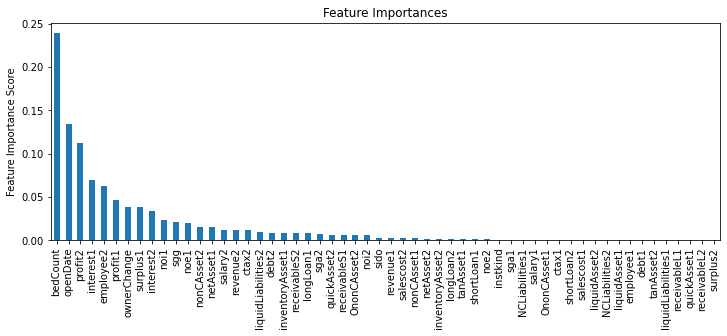

In [27]:
#Choose all predictors except target & IDcols
predictors = [x for x in train_prod.columns if x not in [target,IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train_prod_X, predictors)

1. 상대적으로 높은 학습률을 선택하십시오 . 일반적으로 기본값 0.1이 작동하지만 0.05에서 0.2 사이의 다른 문제에 대해 작동합니다.
1. 이 학습률에 대한 최적의 트리 수를 결정합니다 . 이 범위는 약 40-70입니다. 시스템이 상당히 빠르게 작동 할 수있는 값을 선택하는 것을 잊지 마십시오. 이는 다양한 시나리오를 테스트하고 트리 매개 변수를 결정하는 데 사용되기 때문입니다.
1. 결정된 학습률 및 트리 수에 대한 트리 별 매개 변수 를 조정합니다 . 트리를 정의하기 위해 다른 매개 변수를 선택할 수 있으며 여기서 예제를 살펴 보겠습니다.
1. 더 강력한 모델을 얻으려면 학습률 을 낮추고 추정량을 비례 적으로 늘리십시오.
---

1. min_samples_split = 500 : 전체 값의 ~ 0.5-1 % 여야합니다. 이것은 불균형 클래스 문제이므로 범위에서 작은 값을 취합니다.
1. min_samples_leaf = 50 : 직감에 따라 선택 가능. 이것은 불균형 클래스로 인해 과적 합 및 다시 작은 값을 방지하는 데 사용됩니다.
1. max_depth = 8 : 관측치 및 예측 자 수에 따라 선택해야합니다 (5-8). 여기에는 87K 행과 49 개의 열이 있으므로 여기에서 8 개를 가져옵니다.
1. max_features = 'sqrt' : 제곱근 으로 시작하는 일반적인 규칙입니다.
1. subsample = 0.8 : 일반적으로 사용되는 시작 값입니다.

In [28]:
#Choose all predictors except target & IDcols
predictors = [x for x in train_prod_X.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':range(1,50,10), 'min_samples_split':range(2,5,1),'max_depth':range(5,9),'max_features':['sqrt','auto']}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_prod_X[predictors],train_prod_Y)

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(random_state=10,
                                                  subsample=0.8),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(5, 9),
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_split': range(2, 5),
                         'n_estimators': range(1, 50, 10)},
             scoring='roc_auc')

In [29]:
gsearch1.best_estimator_

GradientBoostingClassifier(max_depth=5, max_features='auto',
                           min_samples_split=3, n_estimators=11,
                           random_state=10, subsample=0.8)

In [30]:
GradientBoostingClassifier(max_depth=5, max_features='auto',
                           min_samples_leaf=50, n_estimators=31,
                           random_state=10, subsample=0.8)

GradientBoostingClassifier(max_depth=5, max_features='auto',
                           min_samples_leaf=50, n_estimators=31,
                           random_state=10, subsample=0.8)

In [31]:
gsearch1.best_estimator_.n_estimators

11

In [32]:
np.random.seed(100)
estimators = gsearch1.best_estimator_.n_estimators
max_depth=gsearch1.best_estimator_.max_depth
max_features=gsearch1.best_estimator_.max_features
min_samples_leaf=gsearch1.best_estimator_.min_samples_leaf
n_estimators=gsearch1.best_estimator_.n_estimators
random_state=gsearch1.best_estimator_.random_state

GBM_prod_tune = GradientBoostingClassifier(n_estimators = estimators ,max_depth=max_depth, max_features=max_features,min_samples_leaf=min_samples_leaf,random_state = random_state )
GBM_prod_model_tune = GBM_prod_tune.fit(train_prod_X, train_prod_Y)
GBM_prod_prediction_tune = GBM_prod_tune.predict_proba(test_prod_X)[:,1]

sub_GBM_tune = pd.DataFrame({'inst_id' : sub_id , 'OC' : GBM_prod_prediction_tune })
sub_GBM_tune = sub_GBM_tune[['inst_id', 'OC']]

In [33]:
sub_GBM_tune

,inst_id,OC
0,2,0.972381
1,5,0.486731
2,6,0.943923
3,8,0.981810
4,10,0.972381
...,...,...
122,424,0.247920
123,425,0.615866
124,429,0.503037
125,430,0.981810


In [34]:
############################################################################
############ GBM
############################################################################
estimators = 20
np.random.seed(100)
GBM_prod = GradientBoostingClassifier(n_estimators = estimators)
GBM_prod_model = GBM_prod.fit(train_prod_X, train_prod_Y)
GBM_prod_prediction = GBM_prod.predict_proba(test_prod_X)[:,1]

sub_GBM = pd.DataFrame({'inst_id' : sub_id , 'OC' : GBM_prod_prediction })
sub_GBM = sub_GBM[['inst_id', 'OC']]

In [35]:
GBM_prod_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [36]:
sub_GBM

,inst_id,OC
0,2,0.971720
1,5,0.201335
2,6,0.452546
3,8,0.986553
4,10,0.971720
...,...,...
122,424,0.212603
123,425,0.578539
124,429,0.489496
125,430,0.984101


In [37]:
sub_GBM['OC'] = [1 if oc>=0.7 else 0 for oc in sub_GBM['OC']] # 튜닝전
sub_GBM_tune['OC'] = [1 if oc>=0.7 else 0 for oc in sub_GBM_tune['OC']] # 튜닝후

In [38]:
close_idx = [5, 6, 24, 30 ,64, 123, 229, 258, 293, 341, 425, 429, 431]
test_prod['OC'] = [0 if id in close_idx else 1 for id in test_prod['inst_id']]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
y_prod_tune = list(sub_GBM_tune['OC'])
y_prod = list(sub_GBM['OC'])
y_true = list(test_prod['OC'])

In [40]:
# Before tuned
print('============Before tuned============')
print(classification_report(y_true, y_prod, target_names=['class 0', 'class 1']))
print(accuracy_score(y_true, y_prod))
# After tuned
print('============After tuned============')
print(classification_report(y_true, y_prod_tune, target_names=['class 0', 'class 1']))
print(accuracy_score(y_true, y_prod_tune))

============Before tuned============
              precision    recall  f1-score   support

     class 0       0.82      0.69      0.75        13
     class 1       0.97      0.98      0.97       114

    accuracy                           0.95       127
   macro avg       0.89      0.84      0.86       127
weighted avg       0.95      0.95      0.95       127

0.952755905511811
============After tuned============
              precision    recall  f1-score   support

     class 0       0.83      0.77      0.80        13
     class 1       0.97      0.98      0.98       114

    accuracy                           0.96       127
   macro avg       0.90      0.88      0.89       127
weighted avg       0.96      0.96      0.96       127

0.9606299212598425


# XGBOOST

In [63]:
############################################################################
############ XGBOOST - tuning
############################################################################
dtrain_prod = xgb.DMatrix(data = train_prod_X, label = train_prod_Y)
dtest_prod = xgb.DMatrix(data = test_prod_X)

#Custom error function for the XGB model
threshold = 0.5
def eval_error(preds, dtrain):
    labels = dtrain.get_label()
    preds = (preds > threshold ).astype('float')
    return "accuracy", accuracy_score(labels, preds)
    

param_tmp = {'eta': [0.1, 0.2, 0.3, 0.4]}
nrounds = 2

In [64]:
xgb_classifier = XGBClassifier(objective='binary:logistic',nthread=1)
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)

random_xgb_tmp = GridSearchCV(xgb_classifier, param_grid = param_tmp, scoring='accuracy', n_jobs=4, cv=skf.split(train_prod_X, train_prod_Y), verbose=2)

In [65]:
random_xgb_tmp.fit(train_prod_X, train_prod_Y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    6.9s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000001C59A4406D0>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, sub

In [83]:
random_xgb_tmp.best_params_['eta'] = 0.1

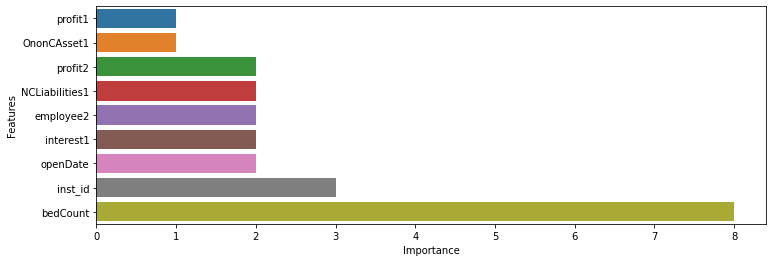

In [84]:
np.random.seed(100)
best_param = {'eta': random_xgb_tmp.best_params_['eta']
         }

xgb_model_tune = xgb.train(best_param, 
                      dtrain_prod, 
                      num_boost_round = nrounds ,
                      feval = eval_error,
                      #maximize = True,
                      #early_stopping_rounds = 10,
                      )

XGB_prediction = xgb_model_tune.predict(dtest_prod)

sub_XGB_tune= pd.DataFrame({'inst_id' : sub_id , 'OC' : XGB_prediction })
sub_XGB_tune= sub_XGB_tune[['inst_id', 'OC']]
  
#PLotting the feature importance
xgb_Imp_tune = pd.DataFrame({'Features' : list(xgb_model_tune.get_score().keys()), 
                        'Importance' : list(xgb_model_tune.get_score().values())}).sort_values(['Importance'])
plt.figure()
sns.barplot(xgb_Imp_tune.Importance, xgb_Imp_tune.Features)
plt.show()

In [85]:
sub_XGB_tune

,inst_id,OC
0,2,0.593927
1,5,0.548750
2,6,0.427813
3,8,0.593927
4,10,0.593927
...,...,...
122,424,0.548750
123,425,0.423200
124,429,0.427813
125,430,0.593927


In [86]:
sub_XGB_tune['OC'] = [1 if oc>=0.5 else 0 for oc in sub_XGB_tune['OC']]
sub_XGB_tune

,inst_id,OC
0,2,1
1,5,1
2,6,0
3,8,1
4,10,1
...,...,...
122,424,1
123,425,0
124,429,0
125,430,1


In [87]:
############################################################################
############ XGBOOST
############################################################################
dtrain_prod = xgb.DMatrix(data = train_prod_X, label = train_prod_Y)
dtest_prod = xgb.DMatrix(data = test_prod_X)

#Custom error function for the XGB model
threshold = 0.5
def eval_error(preds, dtrain):
    labels = dtrain.get_label()
    preds = (preds > threshold ).astype('float')
    return "accuracy", accuracy_score(labels, preds)
    

param = {'objective' : 'binary:logistic',
         'max_depth' : 6,
         'eta': 0.3,
         'colsample_bytree' : 1,
         'subsample' : 1,
         'silent' : 0
         }

nrounds = 2

[17:07:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




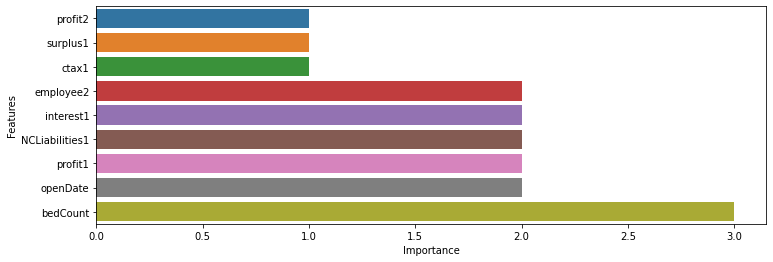

In [88]:
np.random.seed(100)
xgb_model = xgb.train(param, 
                      dtrain_prod, 
                      num_boost_round = nrounds ,
                      feval = eval_error,
                      #maximize = True,
                      #early_stopping_rounds = 10,
                      )

XGB_prediction = xgb_model.predict(dtest_prod)

sub_XGB= pd.DataFrame({'inst_id' : sub_id , 'OC' : XGB_prediction })
sub_XGB= sub_XGB[['inst_id', 'OC']]
  
#PLotting the feature importance
xgb_Imp = pd.DataFrame({'Features' : list(xgb_model.get_score().keys()), 
                        'Importance' : list(xgb_model.get_score().values())}).sort_values(['Importance'])
plt.figure()
sns.barplot(xgb_Imp.Importance, xgb_Imp.Features)
plt.show()

In [89]:
sub_XGB

,inst_id,OC
0,2,0.705177
1,5,0.655411
2,6,0.409096
3,8,0.645067
4,10,0.705177
...,...,...
122,424,0.409096
123,425,0.409096
124,429,0.409096
125,430,0.645067


In [90]:
xgb_model_tune.get_score()

{'bedCount': 8,
 'inst_id': 3,
 'profit2': 2,
 'NCLiabilities1': 2,
 'employee2': 2,
 'interest1': 2,
 'openDate': 2,
 'profit1': 1,
 'OnonCAsset1': 1}

In [91]:
xgb_model.get_score()

{'bedCount': 3,
 'employee2': 2,
 'interest1': 2,
 'profit2': 1,
 'NCLiabilities1': 2,
 'profit1': 2,
 'openDate': 2,
 'surplus1': 1,
 'ctax1': 1}

In [92]:
sub_XGB['OC'] = [1 if oc>=0.5 else 0 for oc in sub_XGB['OC']]
sub_XGB

,inst_id,OC
0,2,1
1,5,1
2,6,0
3,8,1
4,10,1
...,...,...
122,424,0
123,425,0
124,429,0
125,430,1


In [93]:
y_prod_tune_xgb = list(sub_XGB_tune['OC'])
y_prod_xgb = list(sub_XGB['OC'])
y_true = list(test_prod['OC'])

In [94]:
# original
print(classification_report(y_true, y_prod_xgb, target_names=['class 0', 'class 1']))
accuracy_score(y_true, y_prod_xgb)

              precision    recall  f1-score   support

     class 0       0.75      0.92      0.83        13
     class 1       0.99      0.96      0.98       114

    accuracy                           0.96       127
   macro avg       0.87      0.94      0.90       127
weighted avg       0.97      0.96      0.96       127



0.9606299212598425

In [95]:
# tuning
print(classification_report(y_true, y_prod_tune_xgb, target_names=['class 0', 'class 1']))
accuracy_score(y_true, y_prod_tune_xgb)

              precision    recall  f1-score   support

     class 0       0.80      0.92      0.86        13
     class 1       0.99      0.97      0.98       114

    accuracy                           0.97       127
   macro avg       0.90      0.95      0.92       127
weighted avg       0.97      0.97      0.97       127



0.968503937007874

In [96]:
############################################################################
#Ensembling the three models
############################################################################

#Forming the ensemble dataset of the 3 models
ensemble = pd.DataFrame()
ensemble['inst_id'] = sub_XGB['inst_id']
ensemble['XGB'] = sub_XGB['OC']
ensemble['GBM'] = sub_GBM['OC']
ensemble['RF'] = sub_RF['OC']

# Taking the average of all 3 models
ensemble['ens'] = (ensemble['XGB'] + ensemble['GBM'] + ensemble['RF'])/3
ensemble['OC'] = (ensemble['ens'] > 0.7).astype('int') #0.7 as the threshold and above that the hospital is closed.

#Printing to see all the hospitals that are classified as closed 
print(ensemble.loc[ensemble['OC'] == 0, ])

ensemble = ensemble.loc[:, ['inst_id', 'OC']]

#ensemble.to_csv('ens_XGB_7_RF_4_GBM_2_39.csv', index = False)

     inst_id  XGB  GBM  RF       ens  OC
1          5    1    0   1  0.666667   0
2          6    0    0   0  0.000000   0
10        24    0    1   1  0.666667   0
13        30    0    0   1  0.333333   0
20        48    0    1   1  0.666667   0
22        64    0    1   0  0.333333   0
40       123    0    1   1  0.666667   0
52       165    1    1   0  0.666667   0
78       229    0    0   0  0.000000   0
83       254    0    1   1  0.666667   0
84       258    0    0   0  0.000000   0
88       293    0    1   1  0.666667   0
99       341    0    0   0  0.000000   0
120      413    0    0   0  0.000000   0
122      424    0    0   0  0.000000   0
123      425    0    0   1  0.333333   0
124      429    0    0   1  0.333333   0
126      431    0    0   0  0.000000   0


In [97]:
print('''
inst_id       XGB       GBM       RF   ens        OC
1          5  0.657157  0.443177  0.8  0.633445   0
2          6  0.409096  0.666447  0.6  0.558514   0
10        24  0.409096  0.925726  0.7  0.678274   0
13        30  0.409096  0.230173  0.8  0.479756   0
22        64  0.409096  0.936367  0.1  0.481821   0
40       123  0.409096  0.842282  0.7  0.650459   0
78       229  0.409096  0.539125  0.6  0.516074   0
84       258  0.409096  0.442562  0.6  0.483886   0
88       293  0.409096  0.724379  0.7  0.611158   0
99       341  0.409096  0.278068  0.4  0.362388   0
120      413  0.409096  0.278068  0.4  0.362388   0
122      424  0.409096  0.312302  0.3  0.340466   0
123      425  0.409096  0.580902  0.7  0.563333   0
124      429  0.409096  0.536108  0.7  0.548401   0
126      431  0.409096  0.536108  0.6  0.515068   0
''')


inst_id       XGB       GBM       RF   ens        OC
1          5  0.657157  0.443177  0.8  0.633445   0
2          6  0.409096  0.666447  0.6  0.558514   0
10        24  0.409096  0.925726  0.7  0.678274   0
13        30  0.409096  0.230173  0.8  0.479756   0
22        64  0.409096  0.936367  0.1  0.481821   0
40       123  0.409096  0.842282  0.7  0.650459   0
78       229  0.409096  0.539125  0.6  0.516074   0
84       258  0.409096  0.442562  0.6  0.483886   0
88       293  0.409096  0.724379  0.7  0.611158   0
99       341  0.409096  0.278068  0.4  0.362388   0
120      413  0.409096  0.278068  0.4  0.362388   0
122      424  0.409096  0.312302  0.3  0.340466   0
123      425  0.409096  0.580902  0.7  0.563333   0
124      429  0.409096  0.536108  0.7  0.548401   0
126      431  0.409096  0.536108  0.6  0.515068   0



In [98]:
ensemble

,inst_id,OC
0,2,1
1,5,0
2,6,0
3,8,1
4,10,1
...,...,...
122,424,0
123,425,0
124,429,0
125,430,1


In [99]:
# accuracy 96.063

참고사이트   
1. Random forest   
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

2. GBM   
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

3. xgboost   
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/